<a href="https://colab.research.google.com/github/Jramirez1995/Joaquin_Ramriez_Portfolio_II/blob/main/JR_IS6733Lab1_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Neural Network to Predict Quality of Wine
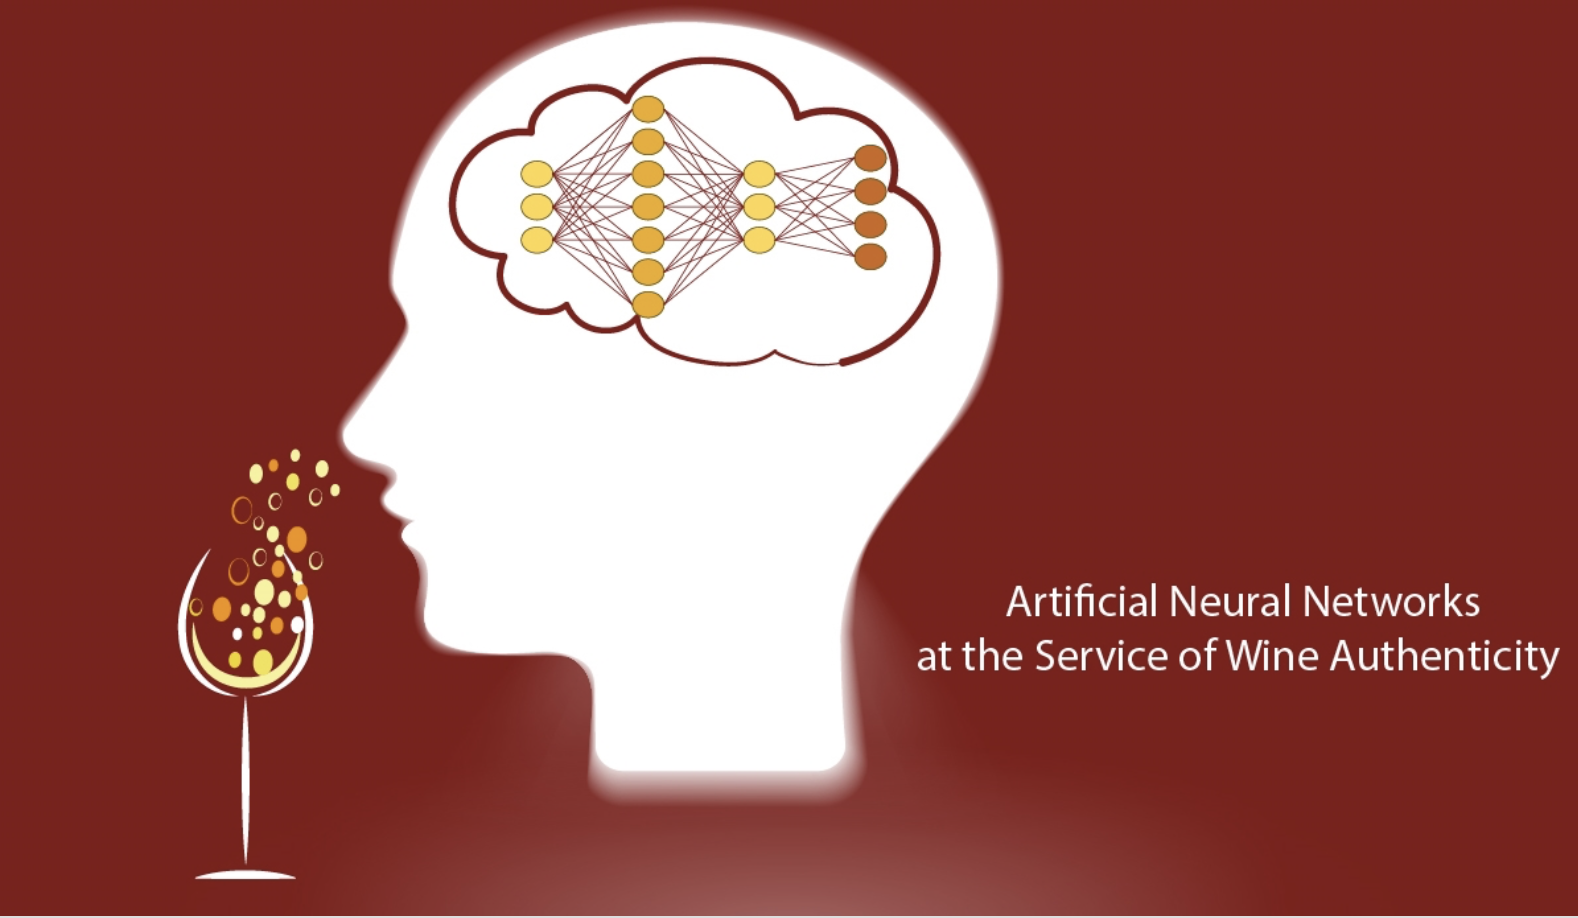
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


## Imports

In [200]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Dataset

In [201]:
data_df = pd.read_csv('winequality-red.csv')

In [202]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [203]:
# how many features?
len(data_df.columns) - 1

11

In [204]:
print(data_df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [205]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [206]:
# convert these quaity measures to labels (0 to 5)
def get_label(quality):
    if quality == 3:
        return 0
    elif quality == 4:
        return 1
    elif quality == 5:
        return 2
    elif quality == 6:
        return 3
    elif quality == 7:
        return 4
    else:
        return 5

labels = data_df['quality'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [207]:
data_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   
1      -0.298454          1.966827    -1.391037        0.043403   0.223805   
2      -0.298454          1.296660    -1.185699       -0.169374   0.096323   
3       1.654339         -1.384011     1.483689       -0.453077  -0.264878   
4      -0.528194          0.961576    -1.391037       -0.453077  -0.243630   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.466047             -0.379014  0.558100  1.288240  -0.579025   
1             0.872365              0.624168  0.028252 -0.719708   0.128910   
2            -0.083643              0.228975  0.134222 -0.331073  -0.048074   
3             0.107558              0.411372  0.664069 -0.978798  -0.461036   
4            -0.466047             -0.379014  0.558100  1.288240  -0.579025   

    alcohol   quality  label  
0 -0.959946 -0.787576      2  
1 -0.584594 -0.787576      2  
2 -0.584594 -0.787576      2  
3 -0.584594  0.450707      3  
4 -0.959946 -0.787576      2

In [208]:
# sumamry statistics of the data
data_df.describe()

fixed acidity  volatile acidity   citric acid  residual sugar  \
count   1.599000e+03      1.599000e+03  1.599000e+03    1.599000e+03   
mean    3.554936e-16      1.688594e-16 -1.066481e-16   -1.110917e-16   
std     1.000000e+00      1.000000e+00  1.000000e+00    1.000000e+00   
min    -2.136377e+00     -2.277567e+00 -1.391037e+00   -1.162333e+00   
25%    -7.004996e-01     -7.696903e-01 -9.290275e-01   -4.530767e-01   
50%    -2.410190e-01     -4.367545e-02 -5.634264e-02   -2.402999e-01   
75%     5.056370e-01      6.264921e-01  7.650078e-01    4.340257e-02   
max     4.353787e+00      5.876138e+00  3.742403e+00    9.192806e+00   

          chlorides  free sulfur dioxide  total sulfur dioxide       density  \
count  1.599000e+03         1.599000e+03          1.599000e+03  1.599000e+03   
mean   2.132961e-16        -6.221137e-17          2.666202e-17 -3.469617e-14   
std    1.000000e+00         1.000000e+00          1.000000e+00  1.000000e+00   
min   -1.603443e+00        -1.422055e+00         -1.230199e+00 -3.537625e+00   
25%   -3.711129e-01        -8.484502e-01         -7.438076e-01 -6.075656e-01   
50%   -1.798892e-01        -1.792441e-01         -2.574163e-01  1.759533e-03   
75%    5.382858e-02         4.899619e-01          4.721707e-01  5.766445e-01   
max    1.112355e+01         5.365606e+00          7.372847e+00  3.678904e+00   

                 pH     sulphates       alcohol       quality        label  
count  1.599000e+03  1.599000e+03  1.599000e+03  1.599000e+03  1599.000000  
mean   2.861723e-15  6.665504e-16  7.109871e-17  6.221137e-17     2.636023  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00     0.807569  
min   -3.699244e+00 -1.935902e+00 -1.898325e+00 -3.264143e+00     0.000000  
25%   -6.549356e-01 -6.380200e-01 -8.661079e-01 -7.875763e-01     2.000000  
50%   -7.210449e-03 -2.250577e-01 -2.092427e-01  4.507074e-01     3.000000  
75%    5.757422e-01  4.238832e-01  6.352984e-01  4.507074e-01     3.000000  
max    4.526866e+00  7.916200e+00  4.201138e+00  2.927275e+00     5.000000

## Load this dataset for training a neural network

In [209]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['fixed acidity'], i['volatile acidity'], i['citric acid'], i['residual sugar'], i['chlorides'], i['free sulfur dioxide'], i['total sulfur dioxide'], i['density'], i['pH'], i['sulphates'], i['alcohol']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [210]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(2), 'features': tensor([-0.5282,  0.9616, -1.3910, -0.4531, -0.2436, -0.4660, -0.3790,  0.5581,
         1.2882, -0.5790, -0.9599])}


## Neural Network

In [211]:
# change the device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [212]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 6)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

winemodel = WineModel().to(device)

## Training

In [222]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr = 1e-3)

In [223]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [224]:
# Let's train our model
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.260 | Train Acc: 78.83% | Val. Loss: 1.395 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.259 | Train Acc: 78.83% | Val. Loss: 1.390 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.261 | Train Acc: 78.67% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.259 | Train Acc: 78.75% | Val. Loss: 1.401 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.389 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.259 | Train Acc: 78.75% | Val. Loss: 1.396 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.395 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.399 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.397 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.392 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.393 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.259 | Train Acc: 78.98% | Val. Loss: 1.405 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.403 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.257 | Train Acc: 79.06% | Val. Loss: 1.397 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.257 | Train Acc: 79.06% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.257 | Train Acc: 78.83% | Val. Loss: 1.391 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.401 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.258 | Train Acc: 78.98% | Val. Loss: 1.389 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.406 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.394 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.258 | Train Acc: 78.98% | Val. Loss: 1.404 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.390 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.399 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.260 | Train Acc: 78.91% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.260 | Train Acc: 78.75% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.399 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.388 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.258 | Train Acc: 78.98% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.399 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.262 | Train Acc: 78.36% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.259 | Train Acc: 78.83% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.388 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.404 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.388 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.259 | Train Acc: 78.75% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.393 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.397 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.403 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.262 | Train Acc: 78.67% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.390 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.389 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.389 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.387 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.388 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.260 | Train Acc: 78.52% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.388 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.399 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.258 | Train Acc: 78.98% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.391 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.259 | Train Acc: 78.83% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.257 | Train Acc: 79.06% | Val. Loss: 1.388 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.389 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.403 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.264 | Train Acc: 78.36% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.397 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.396 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.259 | Train Acc: 78.98% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.258 | Train Acc: 78.98% | Val. Loss: 1.400 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.261 | Train Acc: 78.52% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.257 | Train Acc: 78.83% | Val. Loss: 1.408 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.402 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.396 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.389 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.396 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.387 | Val. Acc: 65.62% |


# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)


Note:

*   Test Loss: 1.399 - test loss suggests that the model's predictions are reasonably close to true.

*   Test Acc: 64.79% - this means that the model correctly classified about 64 out of 100 samples.

*    Precision: 61% - the model predicts positive classes, it is correct 61% of the time.

*   Recall: 65% - the model's can identify 64% of all true positives.

*   F1-score: 63% - the model is well balanced and can distinguish between precision and recall, and the model is moderately balanced.






In [225]:
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppress warnings
warnings.filterwarnings("ignore")

# Define evaluation function for validation/test
def evaluate_model_on_split(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for d in data_loader:
            inputs = d['features'].to(device)
            labels = d['labels'].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            # Collect predictions and labels for metrics
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = epoch_acc / len(data_loader)

    # Calculate precision, recall, and F1 score
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, avg_acc, precision, recall, f1

# Training loop
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate_model_on_split(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% | Precision: {valid_precision:.2f} | Recall: {valid_recall:.2f} | F1-score: {valid_f1:.2f} |')



  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.389 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.262 | Train Acc: 78.52% | Val. Loss: 1.396 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.392 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.259 | Train Acc: 78.67% | Val. Loss: 1.397 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.262 | Train Acc: 78.52% | Val. Loss: 1.398 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.394 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.396 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.404 | Val. Acc: 63.75% | Precision: 0.60 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.390 | Val. Acc: 66.25% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.404 | Val. Acc: 63.12% | Precision: 0.60 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.400 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.265 | Train Acc: 78.12% | Val. Loss: 1.393 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.393 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.254 | Train Acc: 78.98% | Val. Loss: 1.386 | Val. Acc: 66.25% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.394 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.389 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.391 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.384 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.258 | Train Acc: 78.75% | Val. Loss: 1.399 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.261 | Train Acc: 78.44% | Val. Loss: 1.397 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.393 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.65 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.396 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.388 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.391 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.388 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.388 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.65 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.390 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.396 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.397 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.257 | Train Acc: 78.91% | Val. Loss: 1.394 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.389 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.260 | Train Acc: 78.44% | Val. Loss: 1.388 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.392 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.258 | Train Acc: 78.91% | Val. Loss: 1.400 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.392 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.260 | Train Acc: 78.52% | Val. Loss: 1.387 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.389 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.255 | Train Acc: 78.98% | Val. Loss: 1.392 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.408 | Val. Acc: 63.12% | Precision: 0.60 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.393 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.389 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 63.75% | Precision: 0.60 | Recall: 0.64 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.397 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.393 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.394 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.399 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.387 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.256 | Train Acc: 79.06% | Val. Loss: 1.389 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.386 | Val. Acc: 66.25% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.385 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.394 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.258 | Train Acc: 78.75% | Val. Loss: 1.405 | Val. Acc: 63.12% | Precision: 0.60 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.400 | Val. Acc: 63.12% | Precision: 0.59 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.386 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.390 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.398 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.390 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.262 | Train Acc: 78.44% | Val. Loss: 1.392 | Val. Acc: 63.75% | Precision: 0.60 | Recall: 0.64 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.396 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.395 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.394 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.390 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.397 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.401 | Val. Acc: 63.75% | Precision: 0.60 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.262 | Train Acc: 78.75% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.394 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.395 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.253 | Train Acc: 79.14% | Val. Loss: 1.396 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.404 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.259 | Train Acc: 78.75% | Val. Loss: 1.400 | Val. Acc: 62.50% | Precision: 0.59 | Recall: 0.62 | F1-score: 0.60 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.257 | Train Acc: 78.98% | Val. Loss: 1.405 | Val. Acc: 63.12% | Precision: 0.61 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.398 | Val. Acc: 63.12% | Precision: 0.60 | Recall: 0.63 | F1-score: 0.61 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.258 | Train Acc: 78.83% | Val. Loss: 1.403 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.255 | Train Acc: 79.14% | Val. Loss: 1.396 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.392 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.254 | Train Acc: 79.06% | Val. Loss: 1.391 | Val. Acc: 65.62% | Precision: 0.62 | Recall: 0.66 | F1-score: 0.64 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.397 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.255 | Train Acc: 79.06% | Val. Loss: 1.396 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.256 | Train Acc: 78.91% | Val. Loss: 1.404 | Val. Acc: 63.75% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.257 | Train Acc: 79.14% | Val. Loss: 1.392 | Val. Acc: 65.00% | Precision: 0.62 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.256 | Train Acc: 78.98% | Val. Loss: 1.395 | Val. Acc: 64.38% | Precision: 0.61 | Recall: 0.64 | F1-score: 0.62 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.254 | Train Acc: 79.14% | Val. Loss: 1.392 | Val. Acc: 65.00% | Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.254 | Train Acc: 79.22% | Val. Loss: 1.395 | Val. Acc: 65.62% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


In [227]:
# After training, evaluate on the test set
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_model_on_split(winemodel, test_dataloader, criterion)

# Report results on test set
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
print(f'| Precision: {test_precision:.2f} | Recall: {test_recall:.2f} | F1-score: {test_f1:.2f} |')

| Test Loss: 1.399 | Test Acc: 64.79% |
| Precision: 0.61 | Recall: 0.65 | F1-score: 0.63 |



*   Test Loss: 1.399 -  test loss suggests that the model's predictions are reasonably close to true.
*   Test Acc: 64.79% - this means that the model correctly classified about 64 out of 100 samples.
*   Precision: 61% - the model predicts positive classes, it is correct 61% of the time.
*   Recall: 65% - the model's can identify 64% of all true positives.
*   F1-score: 63% - the model is well balanced and can distinguish between precision and recall, and the model is moderately balanced.












## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?





*   Train Loss: 1.263
*   Train Acc: 78.44%
*   Val. Loss: 1.384
*   Val Acc: 66.88%
*   Test Loss: 1.401
*   Test Acc: 63.54%




Note: After increasing the number of epochs and the learning rate, the test accuracy decreased a couple of points compared to the original test accuracy results. This indicates that the changes did not improve the model's performance. Additionally, I observed overfitting, as there is a noticeable gap between training accuracy (78.44%) and test accuracy (63.54%).

In [219]:
optimizer = AdamW(winemodel.parameters(), lr=1.5e-3)  # Adjust the learning rate if necessary

# Increase the number of epochs
num_epochs = 150

# Train the model for more epochs
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Finally, evaluate on test set
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

  0%|          | 0/320 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


| Epoch: 01 | Train Loss: 1.278 | Train Acc: 77.19% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.277 | Train Acc: 77.27% | Val. Loss: 1.402 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.280 | Train Acc: 77.03% | Val. Loss: 1.410 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.285 | Train Acc: 76.72% | Val. Loss: 1.411 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.277 | Train Acc: 77.11% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.275 | Train Acc: 77.50% | Val. Loss: 1.411 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.275 | Train Acc: 77.42% | Val. Loss: 1.398 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.274 | Train Acc: 77.42% | Val. Loss: 1.400 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.278 | Train Acc: 77.03% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.278 | Train Acc: 77.27% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.283 | Train Acc: 76.88% | Val. Loss: 1.407 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.291 | Train Acc: 75.78% | Val. Loss: 1.400 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.280 | Train Acc: 76.95% | Val. Loss: 1.408 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.278 | Train Acc: 77.34% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.276 | Train Acc: 77.42% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.277 | Train Acc: 77.27% | Val. Loss: 1.406 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.282 | Train Acc: 76.72% | Val. Loss: 1.390 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.273 | Train Acc: 77.58% | Val. Loss: 1.392 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.272 | Train Acc: 77.58% | Val. Loss: 1.395 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.276 | Train Acc: 77.27% | Val. Loss: 1.406 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.278 | Train Acc: 77.34% | Val. Loss: 1.405 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.291 | Train Acc: 75.94% | Val. Loss: 1.410 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.275 | Train Acc: 77.42% | Val. Loss: 1.402 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.274 | Train Acc: 77.58% | Val. Loss: 1.405 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.278 | Train Acc: 77.27% | Val. Loss: 1.418 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.284 | Train Acc: 76.72% | Val. Loss: 1.398 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.277 | Train Acc: 77.11% | Val. Loss: 1.385 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.275 | Train Acc: 77.58% | Val. Loss: 1.404 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.275 | Train Acc: 77.50% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.274 | Train Acc: 77.58% | Val. Loss: 1.396 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.281 | Train Acc: 76.88% | Val. Loss: 1.390 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.272 | Train Acc: 77.58% | Val. Loss: 1.412 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.276 | Train Acc: 77.42% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.277 | Train Acc: 77.34% | Val. Loss: 1.418 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.276 | Train Acc: 77.27% | Val. Loss: 1.406 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.280 | Train Acc: 76.88% | Val. Loss: 1.401 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.276 | Train Acc: 77.19% | Val. Loss: 1.400 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.273 | Train Acc: 77.50% | Val. Loss: 1.401 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.274 | Train Acc: 77.66% | Val. Loss: 1.409 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.283 | Train Acc: 76.80% | Val. Loss: 1.386 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.280 | Train Acc: 76.88% | Val. Loss: 1.400 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.272 | Train Acc: 77.73% | Val. Loss: 1.404 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.271 | Train Acc: 77.58% | Val. Loss: 1.398 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.276 | Train Acc: 77.27% | Val. Loss: 1.411 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.282 | Train Acc: 76.72% | Val. Loss: 1.396 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.274 | Train Acc: 77.42% | Val. Loss: 1.391 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.270 | Train Acc: 77.89% | Val. Loss: 1.406 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.271 | Train Acc: 77.89% | Val. Loss: 1.397 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.272 | Train Acc: 77.66% | Val. Loss: 1.410 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.272 | Train Acc: 77.66% | Val. Loss: 1.392 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.279 | Train Acc: 77.03% | Val. Loss: 1.409 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.396 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.272 | Train Acc: 77.58% | Val. Loss: 1.405 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.274 | Train Acc: 77.42% | Val. Loss: 1.400 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.272 | Train Acc: 77.73% | Val. Loss: 1.391 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.274 | Train Acc: 77.50% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.403 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.275 | Train Acc: 77.34% | Val. Loss: 1.391 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.275 | Train Acc: 77.34% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.271 | Train Acc: 77.73% | Val. Loss: 1.394 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.272 | Train Acc: 77.66% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.272 | Train Acc: 77.66% | Val. Loss: 1.398 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.269 | Train Acc: 77.97% | Val. Loss: 1.401 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.269 | Train Acc: 77.89% | Val. Loss: 1.399 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.269 | Train Acc: 77.89% | Val. Loss: 1.412 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.272 | Train Acc: 77.81% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.271 | Train Acc: 77.97% | Val. Loss: 1.402 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.271 | Train Acc: 77.81% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.274 | Train Acc: 77.66% | Val. Loss: 1.401 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.271 | Train Acc: 77.73% | Val. Loss: 1.402 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.271 | Train Acc: 77.81% | Val. Loss: 1.409 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.269 | Train Acc: 77.97% | Val. Loss: 1.403 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.275 | Train Acc: 77.42% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.391 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.272 | Train Acc: 77.73% | Val. Loss: 1.386 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.273 | Train Acc: 77.50% | Val. Loss: 1.400 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.389 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.272 | Train Acc: 77.66% | Val. Loss: 1.397 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.269 | Train Acc: 77.97% | Val. Loss: 1.407 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.272 | Train Acc: 77.89% | Val. Loss: 1.406 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.406 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.271 | Train Acc: 78.05% | Val. Loss: 1.382 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.274 | Train Acc: 77.42% | Val. Loss: 1.397 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.273 | Train Acc: 77.73% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.273 | Train Acc: 77.58% | Val. Loss: 1.396 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.271 | Train Acc: 77.66% | Val. Loss: 1.395 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.272 | Train Acc: 77.58% | Val. Loss: 1.391 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.273 | Train Acc: 77.73% | Val. Loss: 1.404 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.269 | Train Acc: 77.81% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.267 | Train Acc: 78.05% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.267 | Train Acc: 78.05% | Val. Loss: 1.392 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.267 | Train Acc: 78.12% | Val. Loss: 1.404 | Val. Acc: 62.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.272 | Train Acc: 77.73% | Val. Loss: 1.402 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.275 | Train Acc: 77.27% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.266 | Train Acc: 78.12% | Val. Loss: 1.401 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.267 | Train Acc: 78.12% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.266 | Train Acc: 78.20% | Val. Loss: 1.400 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.270 | Train Acc: 77.89% | Val. Loss: 1.393 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.274 | Train Acc: 77.66% | Val. Loss: 1.403 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.268 | Train Acc: 77.97% | Val. Loss: 1.389 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.388 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 1.266 | Train Acc: 78.36% | Val. Loss: 1.397 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 1.270 | Train Acc: 77.81% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 1.272 | Train Acc: 77.81% | Val. Loss: 1.386 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 1.273 | Train Acc: 77.58% | Val. Loss: 1.404 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 1.271 | Train Acc: 77.81% | Val. Loss: 1.390 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 1.275 | Train Acc: 77.27% | Val. Loss: 1.399 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 1.273 | Train Acc: 77.89% | Val. Loss: 1.402 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 1.267 | Train Acc: 78.36% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 1.267 | Train Acc: 78.36% | Val. Loss: 1.390 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 1.264 | Train Acc: 78.36% | Val. Loss: 1.388 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 1.269 | Train Acc: 77.97% | Val. Loss: 1.394 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 1.265 | Train Acc: 78.44% | Val. Loss: 1.400 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 1.267 | Train Acc: 78.28% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 1.266 | Train Acc: 78.36% | Val. Loss: 1.399 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 1.271 | Train Acc: 77.97% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 1.270 | Train Acc: 77.97% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 1.270 | Train Acc: 78.20% | Val. Loss: 1.399 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 1.266 | Train Acc: 78.36% | Val. Loss: 1.403 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 1.267 | Train Acc: 78.12% | Val. Loss: 1.397 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 1.267 | Train Acc: 78.12% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 1.276 | Train Acc: 77.50% | Val. Loss: 1.395 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 1.268 | Train Acc: 78.28% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 1.268 | Train Acc: 77.89% | Val. Loss: 1.382 | Val. Acc: 67.50% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 1.263 | Train Acc: 78.44% | Val. Loss: 1.398 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 1.265 | Train Acc: 78.28% | Val. Loss: 1.386 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 1.267 | Train Acc: 78.28% | Val. Loss: 1.414 | Val. Acc: 61.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 1.269 | Train Acc: 77.97% | Val. Loss: 1.398 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 1.265 | Train Acc: 78.52% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 1.266 | Train Acc: 78.28% | Val. Loss: 1.406 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 1.265 | Train Acc: 78.12% | Val. Loss: 1.405 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 1.265 | Train Acc: 78.28% | Val. Loss: 1.400 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 1.269 | Train Acc: 78.12% | Val. Loss: 1.387 | Val. Acc: 66.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 1.269 | Train Acc: 78.12% | Val. Loss: 1.399 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 1.266 | Train Acc: 78.28% | Val. Loss: 1.394 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 1.263 | Train Acc: 78.52% | Val. Loss: 1.392 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 1.263 | Train Acc: 78.52% | Val. Loss: 1.392 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 1.262 | Train Acc: 78.52% | Val. Loss: 1.388 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 1.273 | Train Acc: 77.66% | Val. Loss: 1.396 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 1.272 | Train Acc: 77.81% | Val. Loss: 1.396 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 1.266 | Train Acc: 78.36% | Val. Loss: 1.397 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 1.267 | Train Acc: 78.12% | Val. Loss: 1.404 | Val. Acc: 63.75% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 1.268 | Train Acc: 78.12% | Val. Loss: 1.420 | Val. Acc: 61.25% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 1.269 | Train Acc: 78.05% | Val. Loss: 1.391 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 1.262 | Train Acc: 78.44% | Val. Loss: 1.389 | Val. Acc: 65.62% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 1.263 | Train Acc: 78.36% | Val. Loss: 1.400 | Val. Acc: 63.12% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 1.262 | Train Acc: 78.44% | Val. Loss: 1.396 | Val. Acc: 64.38% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 1.268 | Train Acc: 78.12% | Val. Loss: 1.374 | Val. Acc: 66.88% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 1.267 | Train Acc: 78.36% | Val. Loss: 1.391 | Val. Acc: 65.00% |


  0%|          | 0/320 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 1.263 | Train Acc: 78.44% | Val. Loss: 1.384 | Val. Acc: 66.88% |
| Test Loss: 1.401 | Test Acc: 63.54% |


## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.




*   Test Loss: At 3.002
*   Test Accuracy: 61.04%
*   Precision (0.58)
*   Recall (0.61)
*   F1-score (0.59)


The results suggest some overfitting, is present. This tells us that struggles to generalize to unseen data.

In [278]:
class EnhancedWineModel(torch.nn.Module):

    def __init__(self):
        super(EnhancedWineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 256)  # First hidden layer
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(256, 128)  # Second hidden layer
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(128, 64)   # Third hidden layer
        self.activation3 = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        return x

# Initialize the enhanced model
winemodel = EnhancedWineModel().to(device)


In [279]:
# Define the optimizer with the updated learning rate
optimizer = AdamW(winemodel.parameters(), lr=1.5e-3)

# The number of epochs set to a smaller number for testing
num_epochs = 150  # Change back to 150 after testing

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate_model_on_split(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 1.429 | Train Acc: 54.77% | Val. Loss: 1.207 | Val. Acc: 56.25% |
| Epoch: 02 | Train Loss: 1.180 | Train Acc: 58.20% | Val. Loss: 1.155 | Val. Acc: 62.50% |
| Epoch: 03 | Train Loss: 1.139 | Train Acc: 60.16% | Val. Loss: 1.107 | Val. Acc: 59.38% |
| Epoch: 04 | Train Loss: 1.124 | Train Acc: 59.53% | Val. Loss: 1.097 | Val. Acc: 61.25% |
| Epoch: 05 | Train Loss: 1.100 | Train Acc: 61.80% | Val. Loss: 1.098 | Val. Acc: 61.88% |
| Epoch: 06 | Train Loss: 1.077 | Train Acc: 62.27% | Val. Loss: 1.107 | Val. Acc: 62.50% |
| Epoch: 07 | Train Loss: 1.056 | Train Acc: 61.95% | Val. Loss: 1.119 | Val. Acc: 59.38% |
| Epoch: 08 | Train Loss: 1.041 | Train Acc: 63.91% | Val. Loss: 1.183 | Val. Acc: 57.50% |
| Epoch: 09 | Train Loss: 1.033 | Train Acc: 65.23% | Val. Loss: 1.120 | Val. Acc: 62.50% |
| Epoch: 10 | Train Loss: 1.011 | Train Acc: 65.16% | Val. Loss: 1.238 | Val. Acc: 58.75% |
| Epoch: 11 | Train Loss: 0.993 | Train Acc: 65.55% | Val. Loss: 1.143 | Val. Ac

In [280]:
# Evaluate on the test set after training
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_model_on_split(winemodel, test_dataloader, criterion)

# Report results on the test set
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')
print(f'| Precision: {test_precision:.2f} | Recall: {test_recall:.2f} | F1-score: {test_f1:.2f} |')

| Test Loss: 3.002 | Test Acc: 61.04% |
| Precision: 0.58 | Recall: 0.61 | F1-score: 0.59 |


## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.





*    Test Loss: 2.899
*   Test Acc: 66.04%
*   Precision: 0.63
*   Recall: 0.66
*   F1-score: 0.64

The model has improved with a lower tess loss, the test accuracy also increased. Both precision and recall improved slightly. This suggest that the model is improving.


In [281]:
class EnhancedWineModel(torch.nn.Module):

    def __init__(self):
        super(EnhancedWineModel, self).__init__()

        self.linear1 = torch.nn.Linear(11, 300)  # First hidden layer
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(300, 150)  # Second hidden layer
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(150, 64)   # Third hidden layer
        self.activation3 = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        return x





In [282]:
# Initialize the updated model and move it to the device (GPU if available)
winemodel = EnhancedWineModel().to(device)

# Define the loss function and optimizer (with learning rate adjustment)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr=1.5e-3)

# Number of epochs set to 150
num_epochs = 150

# Train the model
for epoch in range(num_epochs):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 1.235 | Train Acc: 54.45% | Val. Loss: 1.091 | Val. Acc: 61.88% |
| Epoch: 02 | Train Loss: 0.994 | Train Acc: 58.13% | Val. Loss: 1.131 | Val. Acc: 58.13% |
| Epoch: 03 | Train Loss: 0.965 | Train Acc: 60.00% | Val. Loss: 1.136 | Val. Acc: 55.00% |
| Epoch: 04 | Train Loss: 0.951 | Train Acc: 59.22% | Val. Loss: 1.027 | Val. Acc: 64.38% |
| Epoch: 05 | Train Loss: 0.912 | Train Acc: 62.97% | Val. Loss: 1.049 | Val. Acc: 56.88% |
| Epoch: 06 | Train Loss: 0.910 | Train Acc: 61.33% | Val. Loss: 0.979 | Val. Acc: 63.12% |
| Epoch: 07 | Train Loss: 0.874 | Train Acc: 62.42% | Val. Loss: 1.057 | Val. Acc: 61.25% |
| Epoch: 08 | Train Loss: 0.873 | Train Acc: 62.58% | Val. Loss: 1.015 | Val. Acc: 59.38% |
| Epoch: 09 | Train Loss: 0.845 | Train Acc: 63.83% | Val. Loss: 1.053 | Val. Acc: 65.00% |
| Epoch: 10 | Train Loss: 0.842 | Train Acc: 63.67% | Val. Loss: 1.045 | Val. Acc: 58.75% |
| Epoch: 11 | Train Loss: 0.814 | Train Acc: 65.70% | Val. Loss: 1.054 | Val. Ac

In [283]:
# Evaluate on the test set after training
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_model_on_split(winemodel, test_dataloader, criterion)

# Report results on the test set
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Precision: {test_precision:.2f} | Recall: {test_recall:.2f} | F1-score: {test_f1:.2f} |')

| Test Loss: 2.899 | Test Acc: 66.04% | Precision: 0.63 | Recall: 0.66 | F1-score: 0.64 |


## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.

In [284]:
# Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

In [285]:
# Load the dataset
data_df = pd.read_csv('breast-cancer.csv')
data_df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [286]:
print("Number of features:", len(data_df.columns) - 1)

Number of features: 31


In [287]:
print("Unique labels:", data_df['diagnosis'].unique())



Unique labels: ['M' 'B']


In [288]:
# Convert diagnosis labels to binary (0 for 'B', 1 for 'M')
data_df['label'] = data_df['diagnosis'].map({'B': 0, 'M': 1})

# Drop non-feature columns
features_df = data_df.drop(columns=['diagnosis', 'label'])

In [289]:
# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_df)
normalized_df = pd.DataFrame(normalized_features, columns=features_df.columns)
normalized_df['label'] = data_df['label']

# Split the data into features and labels
X = normalized_df.drop(columns=['label']).values
y = normalized_df['label'].values

# Split into train, validation, and test sets (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [290]:
# Check the shapes of the datasets
print("Train shape:", X_train.shape, y_train.shape)



Train shape: (398, 31) (398,)


In [291]:
print("Validation shape:", X_val.shape, y_val.shape)

Validation shape: (85, 31) (85,)


In [ ]:
print("Test shape:", X_test.shape, y_test.shape)

Test shape: (86, 31) (86,)


In [292]:
# Custom Dataset Class
class CancerDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.LongTensor([self.labels[idx]])

# Create DataLoader instances
train_dataset = CancerDataset(X_train, y_train)
val_dataset = CancerDataset(X_val, y_val)
test_dataset = CancerDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [293]:
# Define the model
class CancerModel(nn.Module):
    def __init__(self):
        super(CancerModel, self).__init__()
        self.linear1 = nn.Linear(31, 300)  # 30 input features
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(300, 150)  # Additional hidden layer
        self.linear3 = nn.Linear(150, 2)  # Output layer for 2 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return self.softmax(x)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CancerModel().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    for features, labels in tqdm(train_dataloader):
        features, labels = features.to(device), labels.view(-1).to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_acc = train_correct / len(train_dataset)

    # Validation
    model.eval()
    valid_loss = 0
    valid_correct = 0
    with torch.no_grad():
        for features, labels in val_dataloader:
            features, labels = features.to(device), labels.view(-1).to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            valid_correct += (outputs.argmax(dim=1) == labels).sum().item()

    valid_acc = valid_correct / len(val_dataset)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss/len(train_dataloader):.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss/len(val_dataloader):.3f} | Val. Acc: {valid_acc*100:.2f}% |')

# Evaluate on the test set
model.eval()
test_loss = 0
test_correct = 0
y_test_pred = []
with torch.no_grad():
    for features, labels in test_dataloader:
        features, labels = features.to(device), labels.view(-1).to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_correct += (outputs.argmax(dim=1) == labels).sum().item()
        y_test_pred.extend(outputs.argmax(dim=1).cpu().numpy())

test_acc = test_correct / len(test_dataset)
print(f'| Test Loss: {test_loss/len(test_dataloader):.3f} | Test Acc: {test_acc*100:.2f}% |')



  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 0.507 | Train Acc: 89.70% | Val. Loss: 0.384 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 0.366 | Train Acc: 95.48% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 0.344 | Train Acc: 96.48% | Val. Loss: 0.350 | Val. Acc: 97.65% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 0.335 | Train Acc: 97.99% | Val. Loss: 0.346 | Val. Acc: 97.65% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 0.330 | Train Acc: 98.99% | Val. Loss: 0.349 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 0.327 | Train Acc: 98.99% | Val. Loss: 0.351 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 0.327 | Train Acc: 99.25% | Val. Loss: 0.351 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 0.324 | Train Acc: 99.25% | Val. Loss: 0.350 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 0.323 | Train Acc: 99.25% | Val. Loss: 0.350 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 0.323 | Train Acc: 99.25% | Val. Loss: 0.353 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 0.322 | Train Acc: 99.25% | Val. Loss: 0.353 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 0.321 | Train Acc: 99.25% | Val. Loss: 0.354 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 0.320 | Train Acc: 99.50% | Val. Loss: 0.356 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 0.320 | Train Acc: 99.50% | Val. Loss: 0.355 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 0.320 | Train Acc: 99.50% | Val. Loss: 0.355 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 0.319 | Train Acc: 99.75% | Val. Loss: 0.354 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 0.318 | Train Acc: 99.50% | Val. Loss: 0.354 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 0.318 | Train Acc: 99.50% | Val. Loss: 0.354 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 0.318 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 96.47% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 0.317 | Train Acc: 99.75% | Val. Loss: 0.354 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 0.317 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 0.317 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 0.319 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.355 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.356 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.357 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 0.319 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 0.319 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |


  0%|          | 0/13 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 0.316 | Train Acc: 99.75% | Val. Loss: 0.358 | Val. Acc: 95.29% |
| Test Loss: 0.320 | Test Acc: 98.84% |


In [294]:
# Report classification metrics
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.96      1.00      0.98        26

    accuracy                           0.99        86
   macro avg       0.98      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86



The model performs exceptionally well, achieving scores of upper 90's. This suggest that the model is highly effective at dsitinguishing between benign and malignant cases. The model demostrates very high predictive power. Since the model performed exeptionally well, we do have to be aware of overfitting.